# Toy VAE for transaction fraud feature generation

In [1]:
import os
import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, regularizers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras
import pandas as pd

In [2]:
!pip install fastparquet

In [304]:
import os 
print(os.getcwd())

c:\Users\lakat\Downloads\dsProject1


In [305]:
file = os.path.join(os.getcwd()[:-10], "fraud_detection_transactions.parquet.gzip")
df = pd.read_parquet(file)

In [306]:
df.columns.values.tolist()

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [46]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [47]:
df = df.drop(['newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'], axis = 1)

In [48]:
df = df[df.type == "TRANSFER"].drop(["type", "nameOrig", "nameDest"], axis=1)

In [49]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

for col in df.columns:
    df[col] = min_max_scaling(df[col])

In [50]:
test_size = int(len(df) * 0.1) # the test data will be 10% (0.1) of the entire data
train = df.iloc[:-test_size,:].copy()
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = df.iloc[-test_size:,:].copy()
print(train.shape, test.shape)

(479619, 4) (53290, 4)


In [51]:
x_train = train.drop("isFraud", axis = 1).to_numpy()
y_train =  train["isFraud"].to_numpy()
x_test = test.drop("isFraud", axis = 1).to_numpy()
y_test = test["isFraud"].to_numpy()

In [52]:
x_train.shape

(479619, 3)

In [53]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train = x_train / 255.
# x_test = x_test / 255.
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(128)

In [13]:
train_dataset.take(1)

<TakeDataset shapes: (None, 3), types: tf.float32>

In [59]:
input_encoder = (3,)
input_decoder = (2,)

## Encoder

In [60]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    print(epsilon)
    return mean + K.exp(log_var / 2) * epsilon

In [277]:
def encoder(input_encoder):
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Dense(12,
                kernel_initializer='glorot_uniform',
                kernel_regularizer='l2',
                input_shape=(input_encoder[0],) \
               )(inputs)
            
    x = layers.Reshape((2,6), name='Reshape_Layer_1')(x)

    x = layers.Conv1D(8, kernel_size=4, padding='same', name='conv_0')(x)
    x = layers.LeakyReLU(name='lrelu_0')(x)
    
    x = layers.Conv1D(6, kernel_size=3, padding='same', name='conv_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    x = layers.Conv1D(4, kernel_size=2, padding='same', name='conv_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    x = tf.keras.layers.LSTM(8)(x)

    x = layers.Reshape((8,), name='Reshape_Layer_2')(x)
   
    
    flatten = layers.Flatten()(x)
    mean = layers.Dense(2, name='mean')(flatten)
    log_var = layers.Dense(2, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [278]:
enc = encoder(input_encoder)

In [279]:
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 12)           48          input_layer[0][0]                
__________________________________________________________________________________________________
Reshape_Layer_1 (Reshape)       (None, 2, 6)         0           dense_53[0][0]                   
__________________________________________________________________________________________________
conv_0 (Conv1D)                 (None, 2, 8)         200         Reshape_Layer_1[0][0]            
____________________________________________________________________________________________

In [280]:
enc.output

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_var')>)

In [281]:
enc.save('vae-toy_fraud-enc.h5')

In [282]:
input_1 = (2,)
input_2 = (2,)

In [283]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [284]:
final = sampling(input_1,input_2)

Tensor("encoder_output/random_normal:0", shape=(None, 2), dtype=float32)


In [285]:
final.save('sampling.h5')

## Decoder

In [290]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(12, name='dense_1')(inputs)
    x = layers.Reshape((2,6), name='Reshape_Layer')(x)
   
    # Block-1
    x = layers.Conv1D(6, kernel_size=3, padding='same', name='conv_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv1D(12, kernel_size=3, padding='same', name='conv_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    x = layers.Reshape((24,), name='Reshape_Layer_2')(x)
    
    x = layers.Dense(24,
                kernel_initializer='glorot_uniform',
                kernel_regularizer='l2',
               )(x)
    # Block-3
    outputs =layers.Dense(1,
                kernel_initializer='glorot_uniform',
                kernel_regularizer='l2',
               )(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [291]:
dec = decoder(input_decoder)

In [292]:
dec.save('vae-toy_fraud-dec.h5')

In [293]:
optimizer = tf.keras.optimizers.Adam(lr = 0.005)

## Metrics

In [294]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_losss = kl_loss(mean, log_var)
    return  r_loss + kl_losss

## Training

In [295]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [296]:
os.makedirs('tf_vae/toy_fraud/training_weights', exist_ok=True)
os.makedirs('tf_vae/toy_fraud/images', exist_ok=True)

In [297]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for transaction_batch in dataset:
            i += 1
            loss = train_step(transaction_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    

        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #    checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('tf_vae/toy_fraud/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('tf_vae/toy_fraud/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [298]:
train(train_dataset, 100)

Tensor("Encoder_2/encoder_output/random_normal:0", shape=(128, 2), dtype=float32)
Tensor("Encoder_2/encoder_output/random_normal:0", shape=(128, 2), dtype=float32)
Tensor("Encoder_2/encoder_output/random_normal:0", shape=(3, 2), dtype=float32)
Time for epoch 1 is 42.31146264076233 sec
Time for epoch 2 is 28.59513282775879 sec
Time for epoch 3 is 27.486949920654297 sec
Time for epoch 4 is 27.888354063034058 sec
Time for epoch 5 is 28.228455781936646 sec
Time for epoch 6 is 31.31092643737793 sec
Time for epoch 7 is 29.73422932624817 sec
Time for epoch 8 is 32.86926031112671 sec
Time for epoch 9 is 28.703728199005127 sec
Time for epoch 10 is 25.6278715133667 sec
Time for epoch 11 is 25.55897283554077 sec
Time for epoch 12 is 32.75221109390259 sec
Time for epoch 13 is 30.0724675655365 sec
Time for epoch 14 is 34.84840130805969 sec
Time for epoch 15 is 31.454281091690063 sec
Time for epoch 16 is 38.61600065231323 sec
Time for epoch 17 is 39.96690130233765 sec
Time for epoch 18 is 38.9336273

In [299]:
enc.load_weights('tf_vae/toy_fraud/training_weights/enc_99.h5')
dec.load_weights('tf_vae/toy_fraud/training_weights/dec_99.h5')

## Latent Space Projection of Variational Autoencoder Trained on Transactions

tf.Tensor(
[[-0.6694623   0.28427583]
 [ 0.09800812 -0.8903605 ]
 [-0.30047113  0.8191024 ]
 ...
 [-0.6236793   1.9233252 ]
 [ 1.0621816   0.42208922]
 [ 0.6379565   0.15903166]], shape=(5000, 2), dtype=float32)


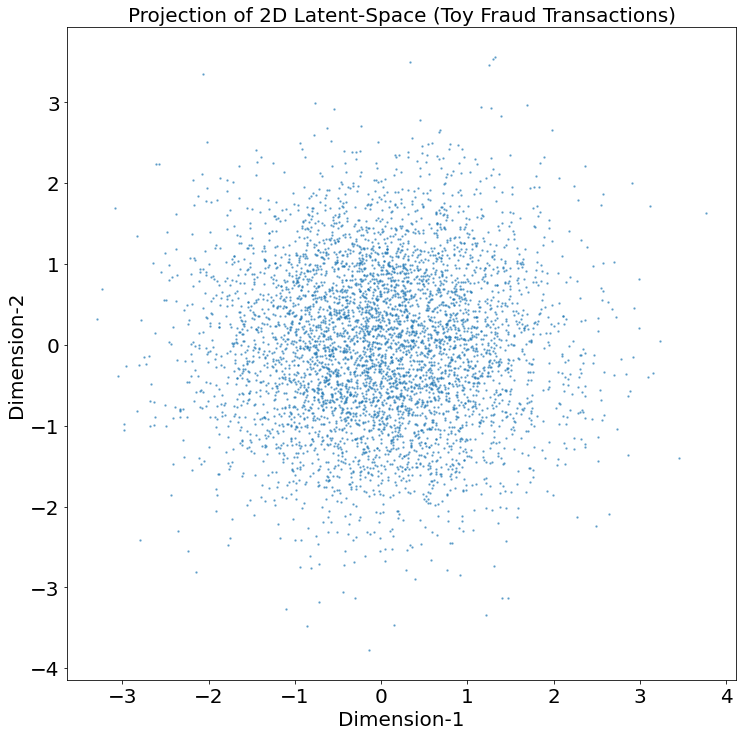

In [300]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

m, v = enc.predict(example_images)
embeddings = final([m,v])



plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Toy Fraud Transactions)", size=20)
plt.show()

In [155]:
# Create dictionary of target classes
label_dict = {
 0: 'Not fraud',
 1: 'Fraud',
}

## Reconstructing Transactions' Fraud feature with Latent-Vector Sampled from Normal Distribution

In [156]:
figsize = 15

x = np.random.normal(size = (10,2))
#x = np.random.uniform(size = (10,200))
reconstruct = dec.predict(x)

In [157]:
reconstruct

array([[0.16518089],
       [0.16588596],
       [0.16491792],
       [0.16575366],
       [0.16452223],
       [0.16626656],
       [0.16567332],
       [0.16547947],
       [0.16586432],
       [0.16519243]], dtype=float32)

## Reconstructing Test Transactions' Fraud feature

In [158]:
start = 0
for i in range(len(y_test)):
    if y_test[i] == 1:
        start = i
        break
m, v = enc.predict(x_test[start:start + 49])
latent = final([m,v])
reconst = dec.predict(latent)

tf.Tensor(
[[-0.5028684  -0.13234432]
 [ 1.1235347   1.9419212 ]
 [ 1.211597    0.30217022]
 [-0.7276473   0.72303045]
 [ 1.3310434  -0.15014158]
 [-0.7759124  -0.00855695]
 [ 0.1201589   0.72996646]
 [-2.41856     0.2759032 ]
 [ 0.4153118  -1.8246846 ]
 [-0.04153842 -0.31987607]
 [-0.65430284  1.0920979 ]
 [ 0.5411113   1.1503149 ]
 [ 0.85901564 -1.4993172 ]
 [ 0.19360052  0.13159034]
 [ 0.0477905   1.5856719 ]
 [-0.11166362 -1.1445298 ]
 [ 0.38020852  1.817826  ]
 [-0.4369163   1.1799055 ]
 [-0.22729747 -0.65854615]
 [-0.05406525 -1.5915408 ]
 [ 0.4352019   2.318363  ]
 [-0.67400026  1.127527  ]
 [-0.27488127 -0.7046427 ]
 [ 1.3695471   0.96998036]
 [ 0.48835886  0.8224141 ]
 [-0.10619102  1.2145053 ]
 [-0.58757627  1.1410577 ]
 [ 0.953696   -1.4945215 ]
 [ 1.4403929  -0.42315856]
 [-1.1839492  -0.41465455]
 [-0.66113794 -0.9375067 ]
 [-1.3229569  -0.44748875]
 [ 0.1576701   0.50287294]
 [ 2.390505   -0.5207009 ]
 [-1.197785   -0.26486874]
 [-0.07470112 -0.5451159 ]
 [-0.19599171 -0.

In [159]:
for i in range(len(reconst)):
    print(reconst[i,0])


0.16582072
0.16552539
0.16505921
0.16615784
0.16487747
0.1659936
0.1657279
0.16691124
0.1649138
0.16553935
0.16621518
0.16561994
0.16477317
0.16553476
0.16598962
0.16535804
0.16587636
0.16612831
0.16554707
0.16522166
0.16598055
0.16623513
0.16555917
0.16515112
0.16556348
0.1659663
0.16619506
0.16472507
0.16475067
0.16609585
0.1656926
0.1661602
0.16564876
0.16423851
0.1661422
0.16550682
0.16562513
0.16584505
0.16490701
0.16500515
0.16611618
0.16523984
0.16579646
0.16645235
0.16478656
0.16549298
0.16637231
0.16520831
0.16511387


In [160]:
for i in range(start,start + 49):
    print(str(label_dict[y_test[i]]))

Fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
Not fraud
